# TVAR PINN with PyTorch
This notebook demonstrates how to use a modern automatic‑differentiation framework (PyTorch)
to learn time‑varying autoregressive (TVAR) coefficients for a simulated signal with constant
sliding‑window power.  The goal is to illustrate how automatic differentiation and an optimiser
such as Adam can replace the manual gradient calculations used previously.


## Background
TVAR models describe signals whose autoregressive coefficients change over time.  Estimating these coefficients
is challenging, particularly when only weak constraints such as constant sliding‑window power are available;
multiple coefficient trajectories can reproduce the same signal【988150528581547†L918-L933】.  We use a physics‑informed neural network
(PINN) to embed prior knowledge into the loss function: an autoregressive residual term, an energy penalty
to enforce constant power, and a smoothness regulariser.  Unlike the earlier implementation, the neural network
and its gradients are implemented using PyTorch, which handles automatic differentiation【672647501557241†L152-L160】.


## Signal Simulation (NumPy)
First, we simulate a one‑dimensional time series governed by a TVAR(2) process.  The underlying AR coefficients
vary slowly and produce low‑frequency oscillatory dynamics reminiscent of local field potentials (LFPs).
The signal is scaled to maintain constant sliding‑window power.

Run the following code cell to generate the simulated signal and display its sliding‑window power.  Adjust the
`freq1`, `freq2`, `P0`, and `W` parameters to modify the underlying dynamics and the window size used for the power constraint.


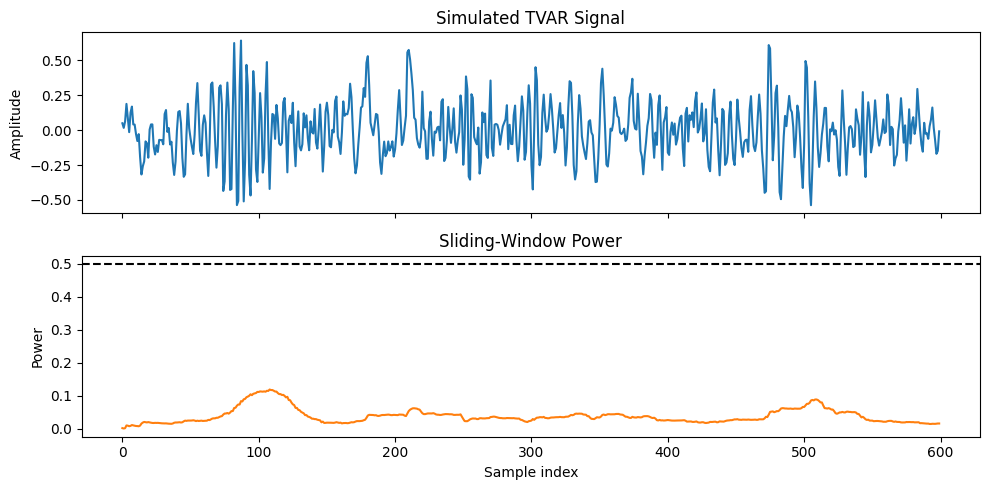

In [1]:

import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
N = 600  # length of the time series
p = 4    # autoregressive order
W = 40   # window length for constant power
P0 = 0.5 # target sliding‑window power
sigma_noise = 0.1

# Frequencies for slowly varying coefficients
freq1 = 1/150
freq2 = 1/200

# Functions generating true AR coefficients
a1_func = lambda t: 0.6 + 0.35 * np.sin(2 * np.pi * freq1 * t)
a2_func = lambda t: -0.5 + 0.25 * np.cos(2 * np.pi * freq2 * t)
a3_func = lambda t: -0.5 + 0.25 * np.cos(2 * np.pi * freq2 * t)

# Generate coefficients over time
coeffs_true = np.zeros((N, p))
for t in range(N):
    coeffs_true[t, 0] = a1_func(t)
    coeffs_true[t, 1] = a2_func(t)

# Simulate the TVAR signal and enforce constant window power
x = np.zeros(N)
np.random.seed(42)
for i in range(N):
    # base white noise
    val = np.random.normal(scale=sigma_noise)
    # autoregressive component
    for k in range(1, p+1):
        if i >= k:
            val += coeffs_true[i, k-1] * x[i-k]
    x[i] = val
    # enforce power constraint after W samples
    if i >= W-1:
        window = x[i-W+1:i+1]
        current_power = np.mean(window**2)
        s = np.sqrt(P0 / current_power) if current_power > 0 else 1.0
        # clip scaling factor to avoid extreme values
        s = np.clip(s, 0.8, 1.2)
        x[i] *= s

# Compute sliding‑window power for plotting
power = np.zeros(N)
for i in range(N):
    start = max(0, i-W+1)
    window = x[start:i+1]
    power[i] = np.mean(window**2)

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax[0].plot(x)
ax[0].set_ylabel('Amplitude')
ax[0].set_title('Simulated TVAR Signal')
ax[1].plot(power, color='tab:orange')
ax[1].axhline(P0, color='k', linestyle='--')
ax[1].set_xlabel('Sample index')
ax[1].set_ylabel('Power')
ax[1].set_title('Sliding‑Window Power')
plt.tight_layout()


In [2]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Simulation parameters
# N = 600  # length of the time series
# p = 4    # autoregressive order
# W = 40   # window length for constant power
# P0 = 0.5 # target sliding-window power
# sigma_noise = 0.1

# # Frequencies for slowly varying coefficients
# freq1 = 1/150
# freq2 = 1/200
# # freq3 = 1/300
# # freq4 = 1/400

# # Functions generating true AR coefficients (for the first two lags)
# a1_func = lambda t: 0.6 + 0.35 * np.sin(2 * np.pi * freq1 * t)
# a2_func = lambda t: -0.5 + 0.25 * np.cos(2 * np.pi * freq2 * t)
# # a3_func = lambda t: -0.5 + 0.25 * np.cos(2 * np.pi * freq3 * t)
# # a4_func = lambda t: -0.5 + 0.15 * np.cos(2 * np.pi * freq4 * t)

# # Generate coefficients over time
# coeffs_true = np.zeros((N, p))
# for t in range(N):
#     if p >= 1:
#         coeffs_true[t, 0] = a1_func(t)
#     if p >= 2:
#         coeffs_true[t, 1] = a2_func(t)

#     # Fill remaining lags (k = 3..p) with small, slowly-varying coefficients
#     # so changing p actually changes the model.
#     for k in range(3, p + 1):
#         # k is 1-indexed lag here; array index is (k-1)
#         amp = 0.12 * (0.7 ** (k - 3))              # decays with lag
#         freqk = freq1 / (k) + freq2 / (k + 1)      # slower for larger lags
#         phase = 0.6 * (k - 2)

#         coeffs_true[t, k - 1] = amp * np.sin(2 * np.pi * freqk * t + phase)

# # Simulate the TVAR signal and enforce constant window power
# x = np.zeros(N)
# np.random.seed(42)
# for i in range(N):
#     # base white noise
#     val = np.random.normal(scale=sigma_noise)
#     # autoregressive component
#     for k in range(1, p+1):
#         if i >= k:
#             val += coeffs_true[i, k-1] * x[i-k]
#     x[i] = val
#     # enforce power constraint after W samples
#     if i >= W-1:
#         window = x[i-W+1:i+1]
#         current_power = np.mean(window**2)
#         s = np.sqrt(P0 / current_power) if current_power > 0 else 1.0
#         # clip scaling factor to avoid extreme values
#         s = np.clip(s, 0.8, 1.2)
#         x[i] *= s

# # Compute sliding-window power for plotting
# power = np.zeros(N)
# for i in range(N):
#     start = max(0, i-W+1)
#     window = x[start:i+1]
#     power[i] = np.mean(window**2)

# # Plot the results
# fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
# ax[0].plot(x)
# ax[0].set_ylabel('Amplitude')
# ax[0].set_title('Simulated TVAR Signal')
# ax[1].plot(power, color='tab:orange')
# ax[1].axhline(P0, color='k', linestyle='--')
# ax[1].set_xlabel('Sample index')
# ax[1].set_ylabel('Power')
# ax[1].set_title('Sliding-Window Power')
# plt.tight_layout()


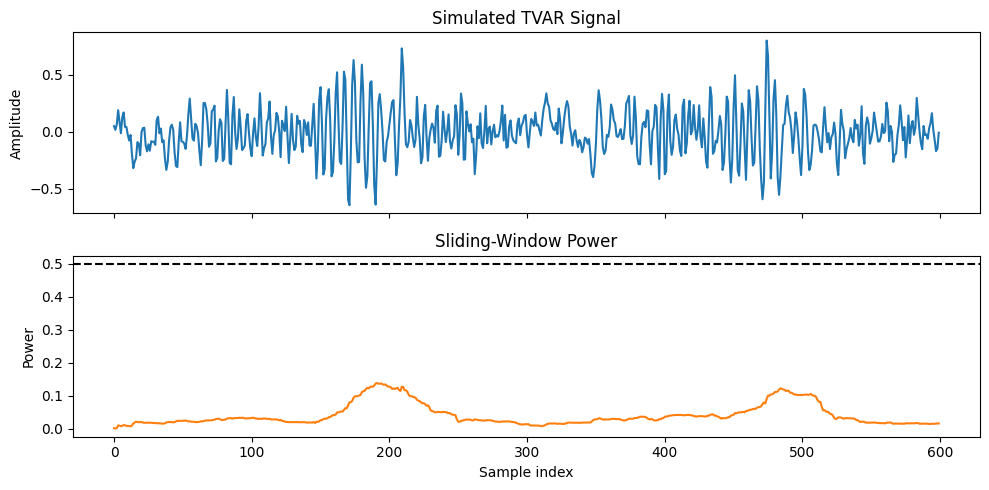

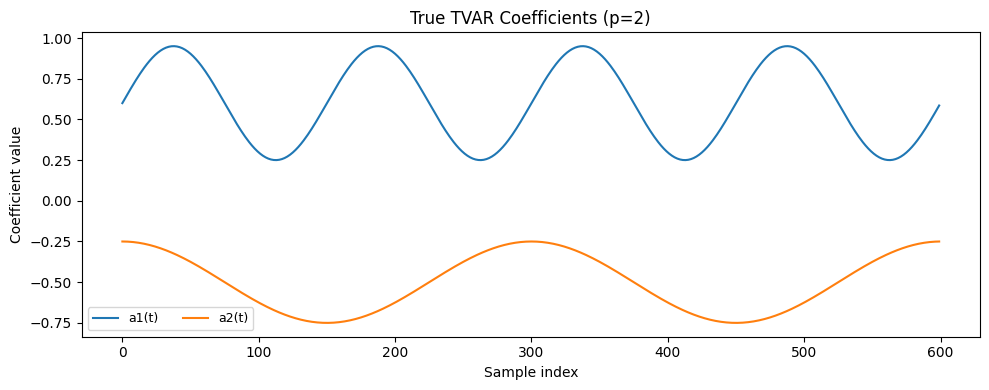

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
N = 600  # length of the time series
p = 2    # autoregressive order
W = 40   # window length for constant power
P0 = 0.5 # target sliding-window power
sigma_noise = 0.1

# Frequencies for slowly varying coefficients
freq1 = 1/150
freq2 = 1/300

# Functions generating true AR coefficients
a1_func = lambda t: 0.6 + 0.35 * np.sin(2 * np.pi * freq1 * t)
a2_func = lambda t: -0.5 + 0.25 * np.cos(2 * np.pi * freq2 * t)

# Generate coefficients over time
coeffs_true = np.zeros((N, p))
for t in range(N):
    if p >= 1:
        coeffs_true[t, 0] = a1_func(t)
    if p >= 2:
        coeffs_true[t, 1] = a2_func(t)

    # Fill remaining lags (k = 3..p) with small, slowly-varying coefficients
    for k in range(3, p + 1):
        amp = 0.72 * (0.7 ** (k - 3))              # decays with lag
        freqk = freq1 / (k) + freq2 / (k + 1)      # slower for larger lags
        phase = 0.6 * (k - 2)
        coeffs_true[t, k - 1] = amp * np.sin(2 * np.pi * freqk * t + phase)

# Simulate the TVAR signal and enforce constant window power
x = np.zeros(N)
np.random.seed(42)
for i in range(N):
    # base white noise
    val = np.random.normal(scale=sigma_noise)
    # autoregressive component
    for k in range(1, p+1):
        if i >= k:
            val += coeffs_true[i, k-1] * x[i-k]
    x[i] = val
    # enforce power constraint after W samples
    if i >= W-1:
        window = x[i-W+1:i+1]
        current_power = np.mean(window**2)
        s = np.sqrt(P0 / current_power) if current_power > 0 else 1.0
        # clip scaling factor to avoid extreme values
        s = np.clip(s, 0.8, 1.2)
        x[i] *= s

# Compute sliding-window power for plotting
power = np.zeros(N)
for i in range(N):
    start = max(0, i-W+1)
    window = x[start:i+1]
    power[i] = np.mean(window**2)

# Plot the results (signal + power)
fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax[0].plot(x)
ax[0].set_ylabel('Amplitude')
ax[0].set_title('Simulated TVAR Signal')
ax[1].plot(power, color='tab:orange')
ax[1].axhline(P0, color='k', linestyle='--')
ax[1].set_xlabel('Sample index')
ax[1].set_ylabel('Power')
ax[1].set_title('Sliding-Window Power')
plt.tight_layout()

# Plot the coefficients
fig2, ax2 = plt.subplots(1, 1, figsize=(10, 4), sharex=True)
for k in range(p):
    ax2.plot(coeffs_true[:, k], label=f'a{k+1}(t)')
ax2.set_xlabel('Sample index')
ax2.set_ylabel('Coefficient value')
ax2.set_title(f'True TVAR Coefficients (p={p})')
ax2.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()


In [4]:
# import numpy as np
# import matplotlib.pyplot as plt

# # -----------------------------
# # Simulation parameters
# # -----------------------------
# N = 500   # length of the time series
# p = 3     # autoregressive order (set this freely; a1..ap will be created)
# W = 40    # window length for constant power
# P0 = 0.5  # target sliding-window power
# sigma_noise = 0.1

# # Base frequencies (slow drift)
# freq1 = 1/100
# freq2 = 1/150

# # -----------------------------
# # Flexible, fully-oscillatory AR coefficient generator
# #   - defines a1(t) ... ap(t) automatically from p
# #   - each ak(t) is a sum of sinusoids (no DC term), i.e., purely oscillatory
# #   - amplitudes decay with lag to keep dynamics stable-ish
# # -----------------------------
# def make_ak_funcs(p, freq1, freq2):
#     """
#     Returns a list of callables [a1(t), a2(t), ..., ap(t)].
#     Each ak(t) is purely oscillatory (sum of sin/cos), with lag-decaying amplitude.
#     """
#     ak_funcs = []

#     for k in range(1, p + 1):
#         # Lag-dependent amplitude decay (tune as needed)
#         amp = 0.05 * (0.72 ** (k - 1))

#         # Make higher lags vary more slowly (still oscillatory)
#         fk1 = freq1 / (1.0 + 0.35 * (k - 1))
#         fk2 = freq2 / (1.0 + 0.50 * (k - 1))

#         # Lag-dependent phases
#         phi1 = 0.9 * (k - 1) + 0.2
#         phi2 = 0.6 * (k - 1) + 1.1

#         # Mix of sin and cos (still zero-mean oscillatory overall)
#         w1 = 0.65
#         w2 = 0.035

#         def ak(t, amp=amp, fk1=fk1, fk2=fk2, phi1=phi1, phi2=phi2, w1=w1, w2=w2):
#             return amp * (w1 * np.sin(2 * np.pi * fk1 * t + phi1) +
#                           w2 * np.cos(2 * np.pi * fk2 * t + phi2))

#         ak_funcs.append(ak)

#     return ak_funcs

# ak_funcs = make_ak_funcs(p, freq1, freq2)

# # -----------------------------
# # Generate coefficients over time
# # -----------------------------
# coeffs_true = np.zeros((N, p))
# for t in range(N):
#     for k in range(1, p + 1):
#         coeffs_true[t, k - 1] = ak_funcs[k - 1](t)

# # -----------------------------
# # Simulate the TVAR signal and enforce (approx) constant window power
# # -----------------------------
# x = np.zeros(N)
# np.random.seed(42)

# for i in range(N):
#     # base white noise
#     val = np.random.normal(scale=sigma_noise)

#     # autoregressive component
#     for k in range(1, p + 1):
#         if i >= k:
#             val += coeffs_true[i, k - 1] * x[i - k]

#     x[i] = val

#     # enforce power constraint after W samples
#     if i >= W - 1:
#         window = x[i - W + 1:i + 1]
#         current_power = np.mean(window**2)
#         s = np.sqrt(P0 / current_power) if current_power > 0 else 1.0
#         s = np.clip(s, 0.8, 1.2)  # clip scaling factor to avoid extremes
#         x[i] *= s

# # -----------------------------
# # Compute sliding-window power for plotting
# # -----------------------------
# power = np.zeros(N)
# for i in range(N):
#     start = max(0, i - W + 1)
#     window = x[start:i + 1]
#     power[i] = np.mean(window**2)

# # -----------------------------
# # Plot the results (signal + power)
# # -----------------------------
# fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
# ax[0].plot(x)
# ax[0].set_ylabel('Amplitude')
# ax[0].set_title('Simulated TVAR Signal')

# ax[1].plot(power, color='tab:orange')
# ax[1].axhline(P0, color='k', linestyle='--')
# ax[1].set_xlabel('Sample index')
# ax[1].set_ylabel('Power')
# ax[1].set_title('Sliding-Window Power')

# plt.tight_layout()

# # -----------------------------
# # Plot the coefficients
# # -----------------------------
# fig2, ax2 = plt.subplots(1, 1, figsize=(10, 4), sharex=True)
# for k in range(p):
#     ax2.plot(coeffs_true[:, k], label=f'a{k+1}(t)')
# ax2.set_xlabel('Sample index')
# ax2.set_ylabel('Coefficient value')
# ax2.set_title(f'True TVAR Coefficients (p={p})')
# ax2.legend(ncol=2, fontsize=9)
# plt.tight_layout()
# plt.show()


## PINN Definition and Training with PyTorch
We now define a simple feed‑forward neural network using PyTorch.  The network takes a normalised time coordinate
`t_norm` as input and outputs two values corresponding to the AR coefficients at that time.  A scaling factor
`scale_coeff` keeps the raw network outputs within a range that tends to yield stable AR processes.

The loss function consists of three terms:
1. **Autoregressive residual** between the observed signal and the one‑step prediction using the predicted coefficients.
2. **Energy penalty** encouraging the sliding‑window power of the predicted signal to match the target `P0`.
3. **Smoothness penalty** on changes in the predicted coefficients over time.

We train the network using the Adam optimiser.  Note that PyTorch must be installed to run this cell; the code
is provided here as a template for execution on systems with PyTorch available.


Epoch 30/300, loss=0.040585, ar=0.018252, energy=0.223328, smooth=0.000000
Epoch 60/300, loss=0.040577, ar=0.018415, energy=0.221620, smooth=0.000000
Epoch 90/300, loss=0.040562, ar=0.018316, energy=0.222459, smooth=0.000000
Epoch 120/300, loss=0.040554, ar=0.018291, energy=0.222631, smooth=0.000000
Epoch 150/300, loss=0.040544, ar=0.018289, energy=0.222557, smooth=0.000000
Epoch 180/300, loss=0.040528, ar=0.018273, energy=0.222553, smooth=0.000000
Epoch 210/300, loss=0.040438, ar=0.018187, energy=0.222512, smooth=0.000000
Epoch 240/300, loss=0.040022, ar=0.017798, energy=0.222247, smooth=0.000003
Epoch 270/300, loss=0.039525, ar=0.017371, energy=0.221536, smooth=0.000016
Epoch 300/300, loss=0.039371, ar=0.017259, energy=0.221115, smooth=0.000028


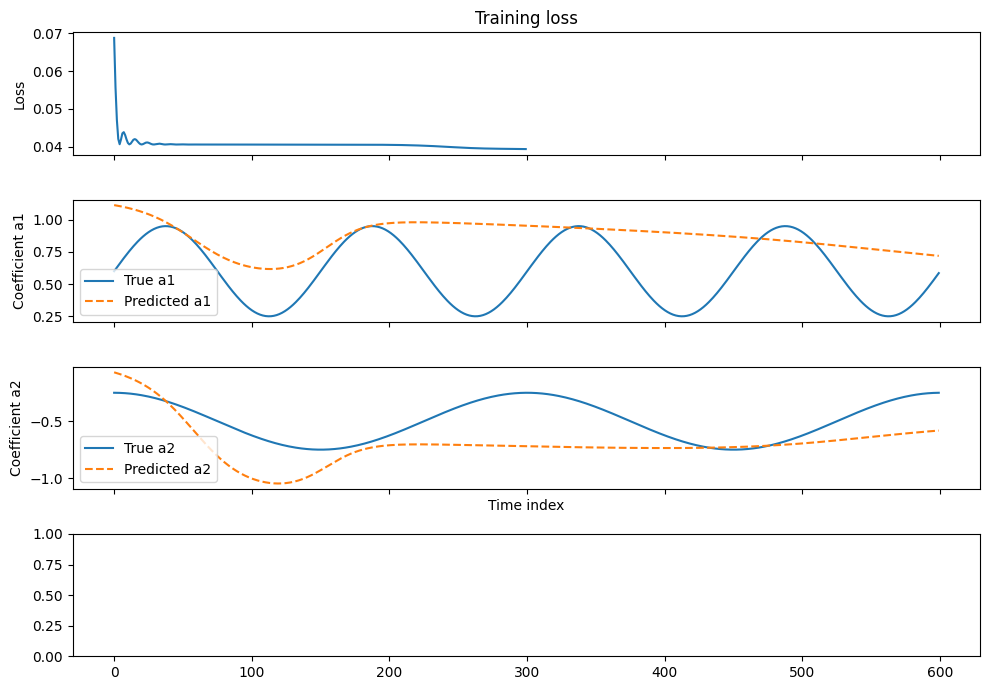

In [5]:

# PyTorch implementation
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Ensure that a GPU is used if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert numpy arrays to torch tensors
x_torch = torch.tensor(x, dtype=torch.float32, device=device)
coeffs_true_torch = torch.tensor(coeffs_true, dtype=torch.float32, device=device)

# Create normalized time input
t_norm = torch.linspace(0.0, 1.0, N, dtype=torch.float32, device=device).view(-1, 1)

class TVARPINN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=40, output_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.activation = torch.tanh
    def forward(self, t):
        x = self.activation(self.fc1(t))
        x = self.activation(self.fc2(x))
        return self.fc3(x)

# Hyperparameters
hidden_dim = 40
scale_coeff = 0.5
lambda_energy = 0.1
lambda_smooth = 0.01
learning_rate = 0.01
n_epochs = 300

# Instantiate model and optimizer
model = TVARPINN(input_dim=1, hidden_dim=hidden_dim, output_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
loss_history = []
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Predict coefficients for all time points, then select those for indices >= p
    coeff_pred = model(t_norm) * scale_coeff
    coeff_pred_use = coeff_pred[p:]
    
    # Compute one‑step predictions using the predicted coefficients
    M = N - p
    x_hat = []
    for i in range(p, N):
        past_vals = torch.tensor([x_torch[i-1], x_torch[i-2]], dtype=torch.float32, device=device)
        coeffs = coeff_pred_use[i - p]
        x_hat.append((coeffs * past_vals).sum())
    x_hat = torch.stack(x_hat)
    
    # Autoregressive residual loss
    y_true = x_torch[p:]
    loss_ar = torch.mean((y_true - x_hat) ** 2)
    
    # Sliding‑window power of the predicted signal
    window_powers = []
    for j in range(M):
        start = max(0, j - W + 1)
        window = x_hat[start:j+1]
        power_hat = torch.mean(window**2)
        window_powers.append(power_hat)
    window_powers = torch.stack(window_powers)
    loss_energy = torch.mean((window_powers - P0) ** 2)
    
    # Smoothness penalty on coefficient differences
    diffs = coeff_pred_use[1:] - coeff_pred_use[:-1]
    loss_smooth = torch.mean(torch.sum(diffs**2, dim=1))
    
    # Total loss
    loss = loss_ar + lambda_energy * loss_energy + lambda_smooth * loss_smooth
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    
    if (epoch+1) % (n_epochs // 10) == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, loss={loss.item():.6f}, ar={loss_ar.item():.6f}, energy={loss_energy.item():.6f}, smooth={loss_smooth.item():.6f}")

# After training, evaluate coefficients over all time
model.eval()
with torch.no_grad():
    coeff_pred_full = model(t_norm) * scale_coeff
coeff_pred_full = coeff_pred_full.cpu().numpy()

# Plot results
fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True)
axes[0].plot(loss_history)
axes[0].set_ylabel('Loss')
axes[0].set_title('Training loss')

axes[1].plot(coeffs_true[:, 0], label='True a1')
axes[1].plot(coeff_pred_full[:, 0], label='Predicted a1', linestyle='--')
axes[1].set_ylabel('Coefficient a1')
axes[1].legend()

axes[2].plot(coeffs_true[:, 1], label='True a2')
axes[2].plot(coeff_pred_full[:, 1], label='Predicted a2', linestyle='--')
axes[2].set_ylabel('Coefficient a2')
axes[2].set_xlabel('Time index')
axes[2].legend()

# axes[3].plot(coeffs_true[:, 2], label='True a2')
# axes[3].plot(coeff_pred_full[:, 2], label='Predicted a3', linestyle='--')
# axes[3].set_ylabel('Coefficient a2')
# axes[3].set_xlabel('Time index')
# axes[3].legend()


# axes[4].plot(coeffs_true[:, 3], label='True a2')
# axes[4].plot(coeff_pred_full[:, 3], label='Predicted a4', linestyle='--')
# axes[4].set_ylabel('Coefficient a2')
# axes[4].set_xlabel('Time index')
# axes[4].legend()

plt.tight_layout()


## Discussion
In this PyTorch implementation, automatic differentiation handles backpropagation through the network and the
complex loss function, simplifying the coding effort compared to manual gradient calculations.
The training loop may still take time to converge, and the estimates for the coefficients may not perfectly match
the true trajectories due to identifiability issues and the weak power constraint.  You can experiment with
different network sizes, loss weights (`lambda_energy`, `lambda_smooth`), learning rates, and epoch counts
to improve performance.  Additionally, consider enforcing stability constraints on the AR coefficients or adding
other physical constraints (e.g., spectral envelopes) to regularise the problem.


## Automatic AR Order Selection with Gated PINN
When the autoregressive order \(p\) is unknown, one approach is to fix a maximum order \(p_{\max}\) and learn
which lags are important using learnable gating weights.  Each lag \(k\) has a gate \(g_k\in[0,1]\); the effective
coefficient at time \(t\) is the product of the gate and the neural network’s output for that lag.  A sparsity
penalty (L\_1 regularisation) on the gates encourages unimportant lags to shrink towards zero.  After training,
the number of gates above a threshold gives an estimated order \(\hat{p}\).

The code below defines a `TVARGatedPINN` class, trains it with a gating penalty, prints the learned gates,
and uses them to reconstruct the signal and plot the results.  You can adjust `p_max`, `lambda_gates`, and
other hyperparameters to suit your data.


Epoch 200/1000, loss=0.066798
Epoch 400/1000, loss=0.067015
Epoch 600/1000, loss=0.067021
Epoch 800/1000, loss=0.066798
Epoch 1000/1000, loss=0.067015
Learned gating weights: [0.00479847 0.00479847 0.00479847 0.00479847 0.00479847 0.00479847]
Estimated AR order (p) ≈ 0


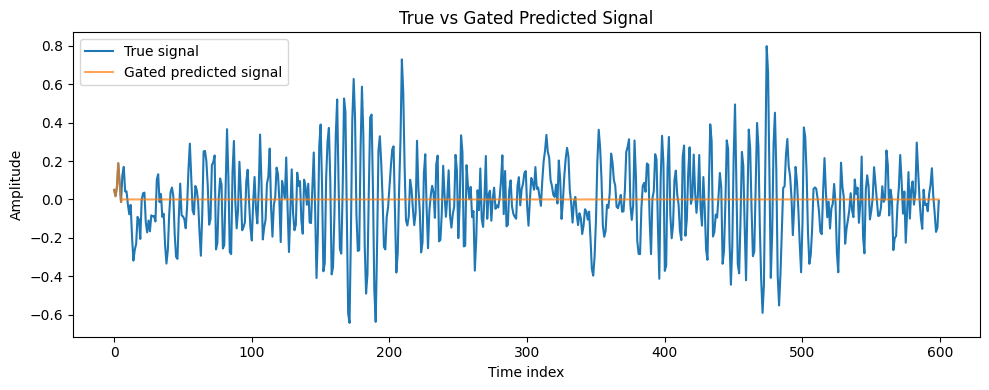

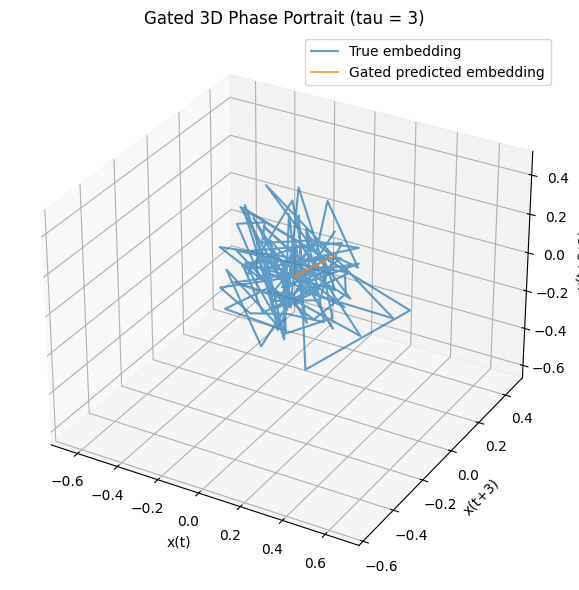

In [11]:

# Gated PINN for automatic order selection
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Maximum AR order to consider
p_max = 6  # adjust as needed

# New network architecture producing p_max coefficients
class TVARGatedPINN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=40, output_dim=p_max):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.activation = torch.tanh
    def forward(self, t):
        x = self.activation(self.fc1(t))
        x = self.activation(self.fc2(x))
        return self.fc3(x)

# Initialise gating weights for each lag (size p_max); start with ones
# We use nn.Parameter so gates are learnable
gates = nn.Parameter(torch.ones(p_max, device=device))

# Hyperparameters for the gated model
hidden_dim_gated = 80
scale_coeff_gated = 0.0
lambda_energy_gated = 0.1
lambda_smooth_gated = 0.01
lambda_gates = 0.01  # sparsity penalty weight on gating weights
learning_rate_gated = 0.01
n_epochs_gated = 1000

# Instantiate model and optimizer (include gates in optimizer parameters)
model_gated = TVARGatedPINN(input_dim=1, hidden_dim=hidden_dim_gated, output_dim=p_max).to(device)
optimizer_gated = optim.Adam(list(model_gated.parameters()) + [gates], lr=learning_rate_gated)

loss_history_gated = []
for epoch in range(n_epochs_gated):
    model_gated.train()
    optimizer_gated.zero_grad()
    
    # Predict coefficients for all time points and apply scaling
    coeff_pred = model_gated(t_norm) * scale_coeff_gated  # shape (N, p_max)
    # Apply gates (broadcast multiply across time dimension)
    coeff_eff = coeff_pred * gates  # shape (N, p_max)
    
    # Compute one-step predictions for each time >= 1
    M = N - 1
    x_hat = []
    for i in range(1, N):
        # Determine how many past lags we can use (up to p_max)
        past_vals = []
        for k in range(1, p_max + 1):
            if i - k >= 0:
                past_vals.append(x_torch[i - k])
            else:
                past_vals.append(torch.tensor(0.0, device=device))
        past_vals = torch.stack(past_vals)
        coeffs = coeff_eff[i]
        x_hat.append((coeffs * past_vals).sum())
    x_hat = torch.stack(x_hat)
    
    # True values
    y_true = x_torch[1:]
    # Loss components
    loss_ar = torch.mean((y_true - x_hat) ** 2)
    # Energy penalty computed on x_hat (sliding window)
    window_powers = []
    for j in range(M):
        start = max(0, j - W + 1)
        window = x_hat[start:j+1]
        power_hat = torch.mean(window**2)
        window_powers.append(power_hat)
    window_powers = torch.stack(window_powers)
    loss_energy = torch.mean((window_powers - P0) ** 2)
    # Smoothness penalty on predicted coefficients
    diffs = coeff_eff[1:] - coeff_eff[:-1]
    loss_smooth = torch.mean(torch.sum(diffs ** 2, dim=1))
    # Sparsity penalty on gates
    loss_gates = torch.sum(torch.abs(gates))
    # Total loss
    loss_total = loss_ar + lambda_energy_gated * loss_energy + lambda_smooth_gated * loss_smooth + lambda_gates * loss_gates
    loss_total.backward()
    optimizer_gated.step()
    loss_history_gated.append(loss_total.item())
    
    if (epoch + 1) % (n_epochs_gated // 5) == 0:
        print(f"Epoch {epoch+1}/{n_epochs_gated}, loss={loss_total.item():.6f}")

# After training, examine the learned gates
with torch.no_grad():
    learned_gates = gates.cpu().numpy()

print("Learned gating weights:", learned_gates)
# Estimate p by counting gates above a threshold (e.g., 0.1)
estimated_p = int((learned_gates > 0.1).sum())
print(f"Estimated AR order (p) ≈ {estimated_p}")

# Use the gated coefficients to compute the predicted signal
with torch.no_grad():
    coeff_pred_full_gated = model_gated(t_norm) * scale_coeff_gated
    coeff_eff_full = coeff_pred_full_gated * learned_gates
coeff_eff_full = coeff_eff_full.cpu().numpy()

# Construct predicted signal using the effective coefficients and observed past samples
pred_signal_gated = np.zeros(N)
pred_signal_gated[:p_max] = x[:p_max]
for i in range(p_max, N):
    past_vals = x[i-p_max:i][::-1]  # most recent first
    pred_signal_gated[i] = np.dot(coeff_eff_full[i][:p_max], past_vals)

# Plot true vs gated predicted signal
plt.figure(figsize=(10, 4))
plt.plot(x, label='True signal')
plt.plot(pred_signal_gated, label='Gated predicted signal', alpha=0.7)
plt.title('True vs Gated Predicted Signal')
plt.xlabel('Time index')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()

# Compute lag embedding using the estimated tau and embedding dimension 3 as in previous section
max_lag = 100
acf = np.zeros(max_lag)
for lag in range(1, max_lag):
    if N - lag > 1:
        corr = np.corrcoef(x[:-lag], x[lag:])[0, 1]
    else:
        corr = 0
    acf[lag] = corr
embedding_tau_gated = 1
for i in range(1, max_lag - 1):
    if acf[i] < acf[i - 1] and acf[i] < acf[i + 1]:
        embedding_tau_gated = i
        break
embedding_dim = 3
max_index = N - (embedding_dim - 1) * embedding_tau_gated
embedding_true = np.column_stack([
    x[j: j + max_index] for j in range(0, embedding_dim * embedding_tau_gated, embedding_tau_gated)
])
embedding_pred_gated = np.column_stack([
    pred_signal_gated[j: j + max_index] for j in range(0, embedding_dim * embedding_tau_gated, embedding_tau_gated)
])

# Plot 3D phase portrait for gated prediction
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
idx = np.arange(0, embedding_true.shape[0], 5)
ax.plot(embedding_true[idx, 0], embedding_true[idx, 1], embedding_true[idx, 2], label='True embedding', alpha=0.7)
ax.plot(embedding_pred_gated[idx, 0], embedding_pred_gated[idx, 1], embedding_pred_gated[idx, 2], label='Gated predicted embedding', alpha=0.7)
ax.set_title(f'Gated 3D Phase Portrait (tau = {embedding_tau_gated})')
ax.set_xlabel('x(t)')
ax.set_ylabel(f'x(t+{embedding_tau_gated})')
ax.set_zlabel(f'x(t+2*{embedding_tau_gated})')
ax.legend()
plt.tight_layout()
plt.show()


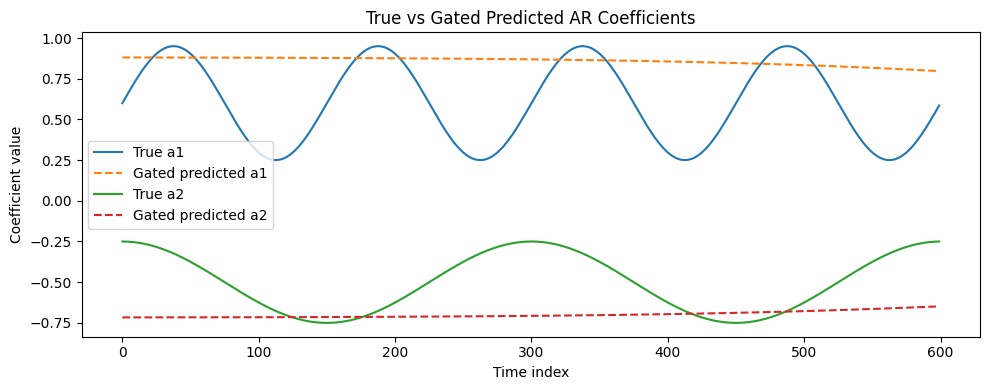

In [10]:

import matplotlib.pyplot as plt

# Determine the number of true AR coefficients
p_true = coeffs_true.shape[1]
# Plot true and gated predicted coefficients for each lag up to p_true
plt.figure(figsize=(10, 4))
for k in range(p_true):
    plt.plot(coeffs_true[:, k], label=f'True a{k+1}')
    plt.plot(coeff_eff_full[:, k], label=f'Gated predicted a{k+1}', linestyle='--')
plt.title('True vs Gated Predicted AR Coefficients')
plt.xlabel('Time index')
plt.ylabel('Coefficient value')
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
p_true

2

#Conclusion

Do a recuirive on the classic PINN and calcualte p by elbow plot. THe advatange of classic PINN is it fully capture the dynamics of phi which is magical tbh!